In [137]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
import requests
from bs4 import BeautifulSoup
import time
from IPython.display import clear_output, display
import pandas as pd
from ipywidgets import IntProgress
import random
import string


In [ ]:
page = requests.get("https://www.frasesdobem.com.br/frases-de-autoestima")
soup = BeautifulSoup(page.text, "html.parser")
links = [
    a.attrs.get("href")
    for a in soup.select_one(".col-md-4.sidebar").select("a")
    if len(a.attrs.get("href")) > 20 and "frases-" in a.attrs.get("href")
]
links[0].split("/")[-1]

In [ ]:
links_extrator = []
links_already_read=[]

host = "https://www.mundodasmensagens.com"
# host = "exemple.com"

qtd = 200

f = IntProgress(min=0, max=qtd) 
display(f)  

def extrator_links(link: str):
    global links_extrator,links_already_read
    
    if link in links_already_read:
        return False

    page = requests.get(link)
    soup = BeautifulSoup(page.text, "html.parser")
    _list = list(
        set(
            [
                host + a.attrs.get("href")
                for a in soup.select("a")
                if len(a.attrs.get("href").split("/")) == 3
            ]
        )
    )

    links_extrator += _list
    links_extrator = list(set(links_extrator))

    for ex_link in links_extrator:
        f.value += 1 
        extrator_links(ex_link)

    if len(links_extrator) > qtd:
        return False

extrator_links(host)

links_extrator

In [51]:
phrases = []
count_next_link = 1


def scraping(link: str):
    global phrases, count_next_link

    clear_output(wait=True)
    print(link, len(phrases))

    page = requests.get(link)
    soup = BeautifulSoup(page.text, "html.parser")

    soup.find("div", id="breadcrumbs").decompose()

    for tag in soup.select(
        "img, .list-content .box-list.box, #list-content .box-list.box, .details-box .box-list.box"
    ):
        if (
            tag.name in "img"
            and tag.attrs.get("alt")
            and len(tag.attrs.get("alt")) > 15
        ):
            phrases.append(tag.attrs.get("alt"))
        elif tag.name in "div":
            social = tag.select(".box-social")
            try:
                if social:
                    for t in tag.select(".box-social"):
                        if t:
                            t.decompose()
            except Exception:
                pass
            phrases.append(tag.text)

    phrases = list(set(phrases))
    #     time.sleep(30)
    count_next_link += 1

    next_link = None

    for link in soup.select(".pagination a"):
        if link.text in str(count_next_link):
            next_link = link.attrs.get("href")

    if not next_link:
        return False

    scraping(host + next_link)


for link_emotion in links_extrator:
    phrases = []
    count_next_link = 1

    path = "generating-data-emotions/{}-{}.csv".format(
        "-".join(
            [a.replace(".html", "") for a in link_emotion.split("/")[-2:] if len(a)]
        ),
        "".join(
            random.choice(string.ascii_uppercase + string.digits) for _ in range(10)
        ),
    )

    print(path)

    scraping(link_emotion)

    df = pd.DataFrame(phrases)
    df.to_csv(path)

https://www.mundodasmensagens.com/imagens-de-boa-noite/ 0


AttributeError: 'NoneType' object has no attribute 'decompose'

<IPython.core.display.Javascript object>

In [54]:
import operator

stats = {"a": 1000, "b": 3000, "c": 100}
max(stats.values())

3000

<IPython.core.display.Javascript object>

In [74]:
import spacy
from spacy import displacy

pln = spacy.load("pt_core_news_lg")

<IPython.core.display.Javascript object>

In [261]:
from os import listdir
from os.path import isfile, join
from spacy import displacy
import types

path = "generating-data-emotions/"
only_files = [f for f in listdir(path) if isfile(join(path, f))]

only_files = [
    {"name": " ".join([a.replace(".csv", "") for a in f.split("-")]), "file": path + f}
    for f in only_files
]
list_df = []

for o in only_files:
    doc = pln(o.get("name"))
        
    o.update(
        word=" ".join(
            [
                token.text
                for token in doc
                if token.is_alpha and not token.is_stop and token.dep_ not in "ROOT" and not token.is_upper
            ]
        )
    )

    df = pd.read_csv(o.get("file"))
    df.columns = ["id", "frase"]
    df["emotion"] = o.get("word")
    list_df.append(df)

df = pd.concat(list_df)
df = df.sample(frac=1).reset_index(drop=True)

df = df[df.notna()]

df


,id,frase,emotion
0,173,"\nVocê foi a pessoa certa na hora certa, padra...",pai
1,66,"\nTrabalhar com você, cliente, é uma alegria d...",agradecimento
2,84,"As mulheres são sempre poderosas, mas uma mulh...",marcantes
3,255,\nAs razões para te amar são todas iguais\n\n\...,amor
4,7,"Para chegar ao castelo, você precisa nadar pel...",motivacao
...,...,...,...
7862,25,"O fácil se faz logo, o difícil demora um pouco...",evangelicas
7863,90,Um primo como você é uma das maiores bênçãos d...,legais
7864,69,\nDizer por escrito o quanto amo você\n\n\n ...,declaracao amor
7865,331,\nO Nome do Sentimento\n\n\n ...,amor


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

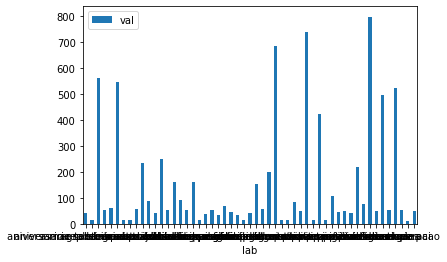

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [200]:
df = pd.DataFrame(
    {
        "lab": df.groupby(["emotion"]).count().index.to_list(),
        "val": df.groupby(["emotion"]).count().frase.to_list(),
    }
)
ax = df.plot.bar(x="lab", y="val", rot=0)

<AxesSubplot:xlabel='emotion', ylabel='count'>

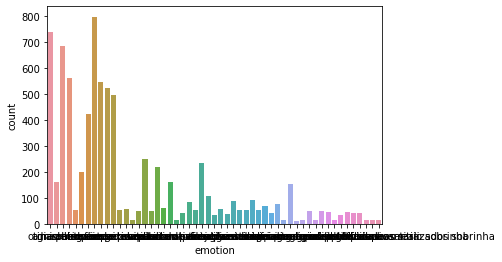

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [217]:
import seaborn as sns

sns.countplot(df.emotion, label="Contagem")

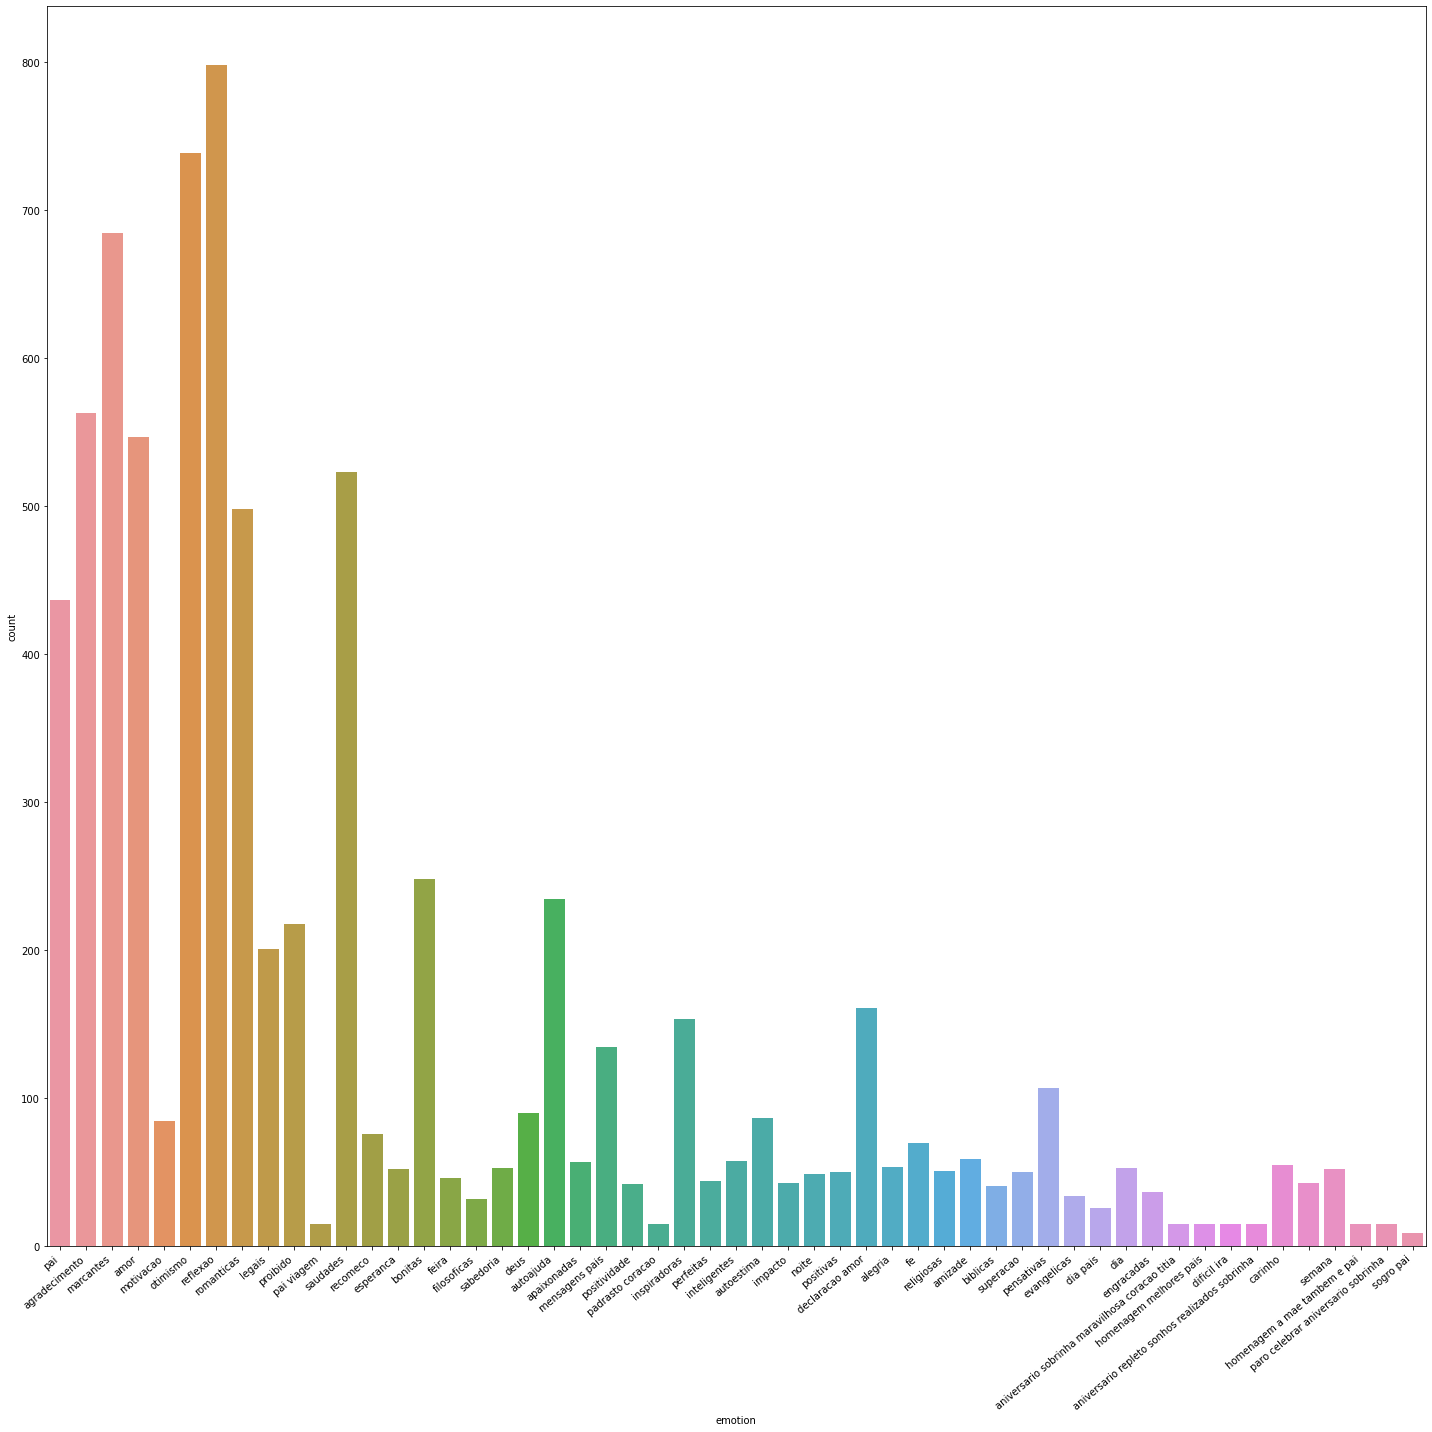

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [262]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

ax = sns.countplot(x="emotion", data=df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [264]:
!rm ./data/treinamento-de-palavras.csv

rm: cannot remove './data/treinamento-de-palavras.csv': No such file or directory


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [265]:
df.to_csv("./data/treinamento-de-palavras.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

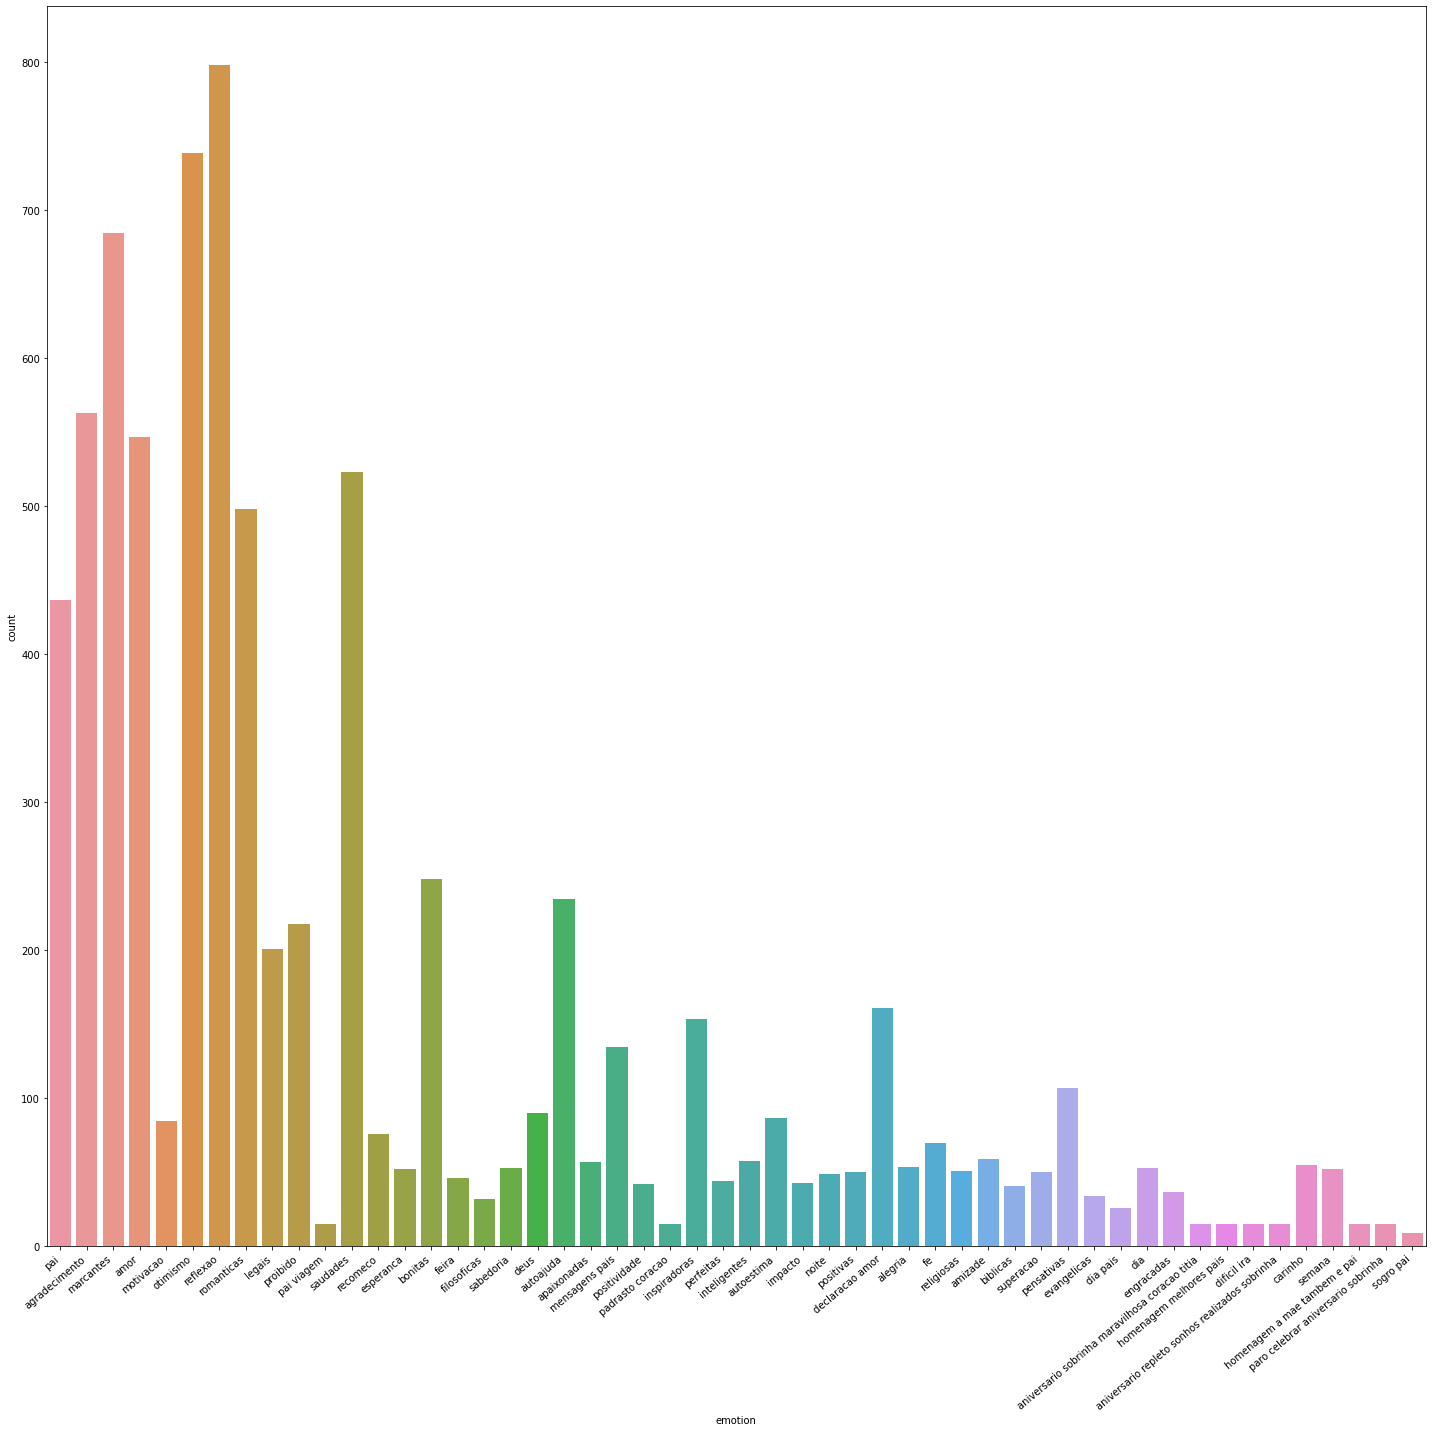

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [273]:
df = pd.read_csv("./data/treinamento-de-palavras.csv")
del df["Unnamed: 0"]
del df["id"]

plt.figure(figsize=(20, 20))

ax = sns.countplot(x="emotion", data=df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [224]:
pln = spacy.load("pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [277]:
def preprocess(text):
    from spacy.lang.pt.stop_words import STOP_WORDS

    _list = [token.lemma_ for token in pln(str(text).lower())]
    return " ".join(
        [
            str(word)
            for word in _list
            if word not in STOP_WORDS
            and word not in string.punctuation
            and not word.isdigit()
        ]
    )


preprocess("Estou aPrendendo 1 10 23 processamento de linguagem natura.")

'aprender processamento linguagem natura'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [279]:
df.emotion = df["emotion"].apply(preprocess)
df

,frase,emotion
0,"\nVocê foi a pessoa certa na hora certa, padra...",pai
1,"\nTrabalhar com você, cliente, é uma alegria d...",agradecimento
2,"As mulheres são sempre poderosas, mas uma mulh...",marcante
3,\nAs razões para te amar são todas iguais\n\n\...,amor
4,"Para chegar ao castelo, você precisa nadar pel...",motivacao
...,...,...
7862,"O fácil se faz logo, o difícil demora um pouco...",evangelicas
7863,Um primo como você é uma das maiores bênçãos d...,legar
7864,\nDizer por escrito o quanto amo você\n\n\n ...,declaracao amor
7865,\nO Nome do Sentimento\n\n\n ...,amor


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

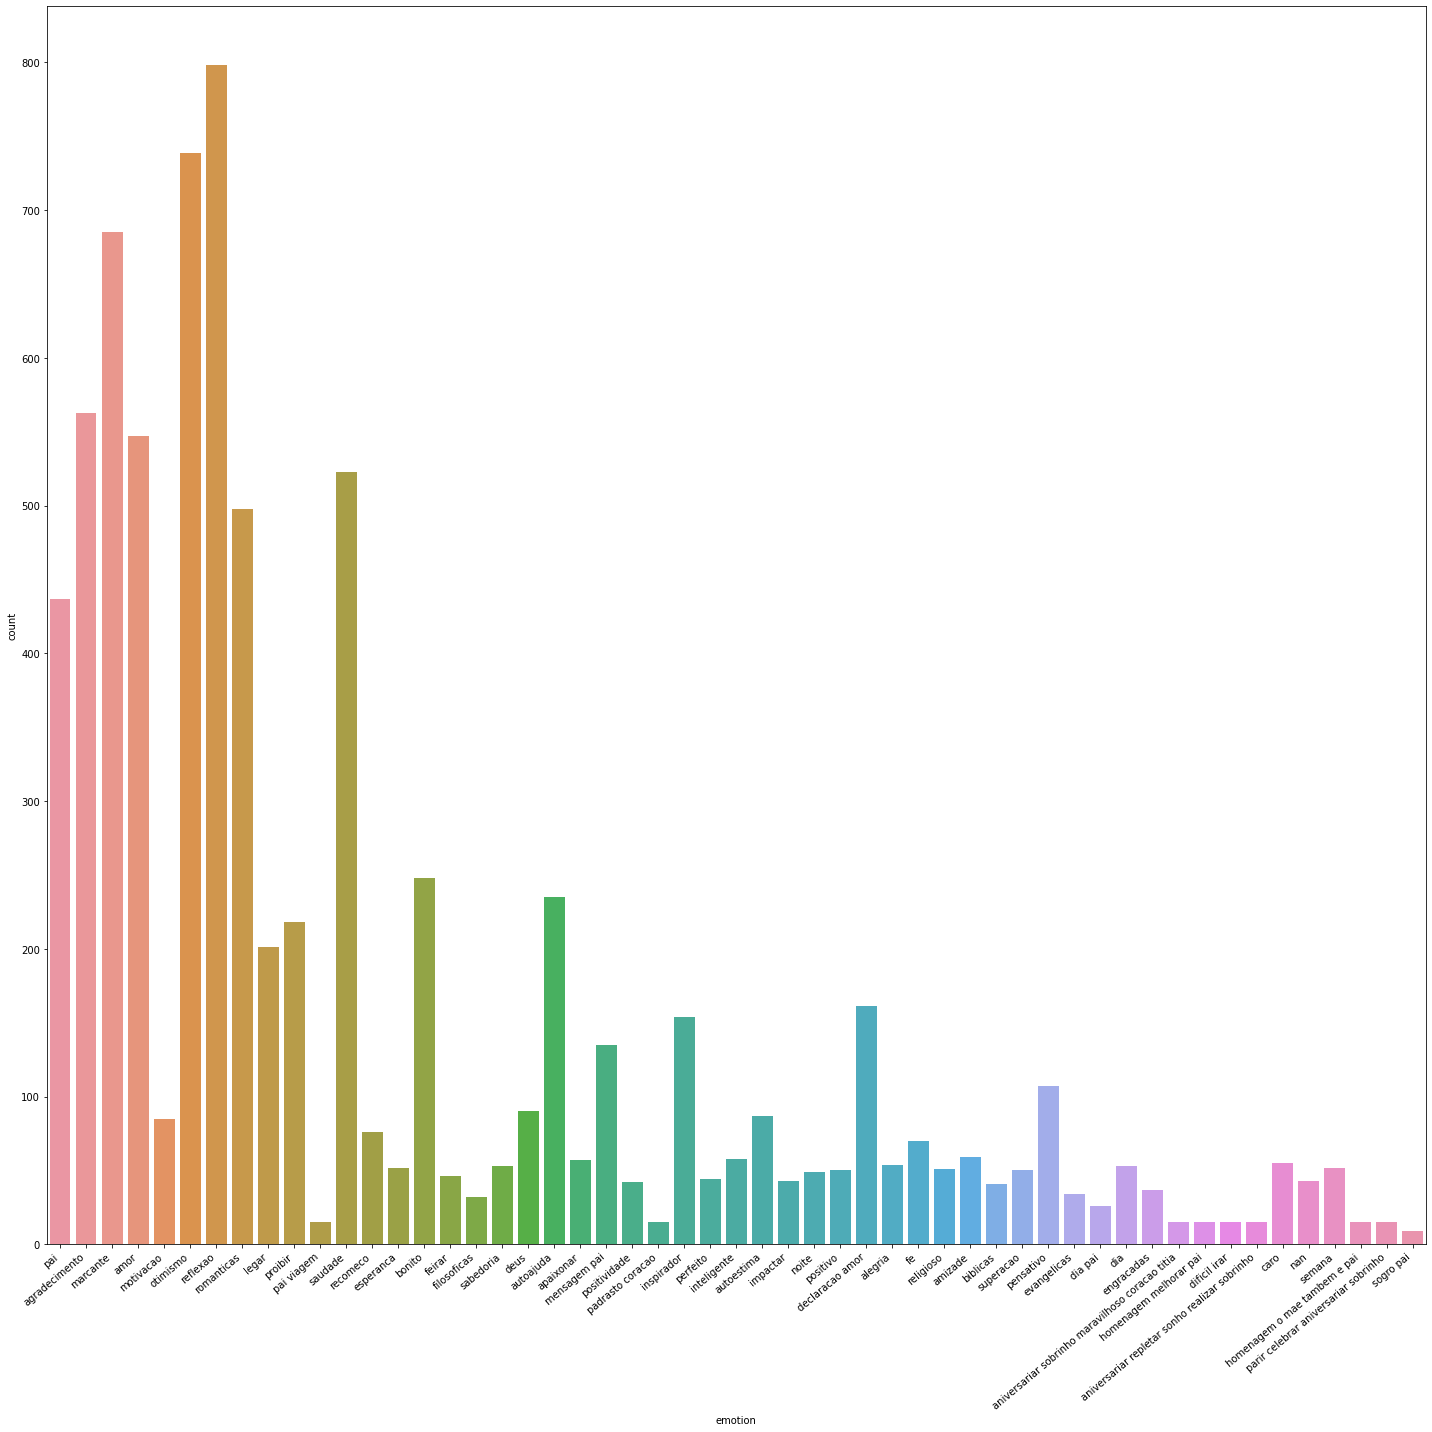

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [280]:
plt.figure(figsize=(20, 20))

ax = sns.countplot(x="emotion", data=df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [290]:
cat = dict({v: False for v in df.emotion.to_list()})
training = []
for text, emotion in zip(df.frase, df.emotion):
    dic = cat.copy()
    dic.update({emotion: True})
    training.append([text, dic.copy()])

training

[['\nVocê foi a pessoa certa na hora certa, padrasto\n\n\n                                    Você é uma daquelas pessoas certas na hora certa, padrasto. Depois que meu pai partiu, eu e minha mãe andávamos muito tristes. Mas você apareceu para trazer vida à nossa casa novamente.\n\r\nSeu jeito conquistou a todos e nos fez renascer. Seremos eternamente gratos por todo amor que você trouxe! Hoje você é como um pai para mim e o amor que sinto por você, só cresce a cada dia.\n\r\nAgradeço por tudo e principalmente por você ser uma pessoa tão incrível!                                \n\n\n',
  {'pai': True,
   'agradecimento': False,
   'marcante': False,
   'amor': False,
   'motivacao': False,
   'otimismo': False,
   'reflexao': False,
   'romanticas': False,
   'legar': False,
   'proibir': False,
   'pai viagem': False,
   'saudade': False,
   'recomeco': False,
   'esperanca': False,
   'bonito': False,
   'feirar': False,
   'filosoficas': False,
   'sabedoria': False,
   'deus': Fal

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [292]:
model = spacy.blank("pt")
category = model.create_pipe("textcat")

for x in df.emotion.to_list():
    category.add_label(x.lower())

model.add_pipe(category)
history = []

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import threading
from ipywidgets import IntProgress
from IPython.display import display

max_epoch = 1000

f = IntProgress(min=0, max=(max_epoch*7))  
display(f)  

model.begin_training()
for epoch in range(max_epoch):
    random.shuffle(training)
    losses = {}
    for batch in spacy.util.minibatch(training, 30):
        f.value += 1 
        text = [model(text) for text, entities in batch]
        annotations = [{'cats': entities} for text, entities in batch]
        model.update(text, annotations, losses=losses)
    if epoch % 100 == 0:
        history.append(losses)


IntProgress(value=0, max=7000)